In [19]:
from sandbox import *

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,precision_recall_curve, auc, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

In [2]:
random_state = 42

# Data loading

We use only 100k of the approximately 550k samples (more than that seems to break the kernel of our handin jupyter notebook) provided in the human_dna_train-&validation_split in this analysis.

In a first step we combine the train&validation_split data since we do a 5-fold crossvalidation of our models. Then we one-hot encode the sequence data resulting in a training dataset with input shape of (sample number, sequence length, amino acids).

In [3]:
df_train = pd.concat([pd.read_csv('exercise_data/human_dna_train_split.csv', header=0, names =['seq', 'label']),
                       pd.read_csv('exercise_data/human_dna_validation_split.csv', header=0, names =['seq', 'label'])])
y_train = df_train.label
x_train = df_train.seq

In [4]:
# TRAINING DATASET

y_train=y_train[:100000]
x_train=x_train[:100000]
x_prep, y_prep = prep_data_cnn(x_train, y_train)

# print(x_prep.shape)
# print(y_prep.shape)
# print((np.asarray(x_prep)).shape)

In [5]:
# TESTING DATASETS
df_test = pd.read_csv('exercise_data/human_dna_test_split.csv', header=0, names =['seq', 'label'])
df_test_hidden = pd.read_csv('exercise_data/human_dna_test_hidden_split.csv', header=0, names =['seq'])
y_test = df_test.label
x_test = df_test.seq
x_testh = df_test_hidden.seq

In [6]:
x_prep_test, y_prep_test = prep_data_cnn(x_test, y_test)

# print(x_prep_test.shape)
# print(y_prep_test.shape)
# print((np.asarray(x_prep_test)).shape)

/home/flurin/machine-learning-for-health-care-project4/sandbox.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y==-1] = 0


In [7]:
x_prep_testh = prep_data_cnn(x_testh, use_y=False)

# print(x_prep_testh.shape)

# Analysis / Methods

Using the one-hot encoded data we here investigate three neural network architectures on their capability to predict splice sites (binary problem described in the project_4 description).

A bit of detail on the 3 architectures we provide:

## 'cnn'

This is a model uses 2 convolutional blocks followed by a 3 feed forward layer blocks. The convolutional block uses a convolutional layer with 32 filters and kernel size 5, followed by a maximum pooling. The onehot-encoded input is passed through the convolutional blocks and is then flattened and further processed by the following feed forward layer block: The feed forward layer blocks are decreasing in number of nodes in the linear layers, starting at 256, 128 and then 85. Between the linear layers of the feed forward layer block we apply ReLU activation function and use dropout of 0.5.


## 'cnn2'

This model uses 2 convolutional blocks with decreasing number of filters. First layer block uses 32 filters the second block uses 16 filters, both use kernel size of 3. We then use maxpooling and apply flatten. Then we use a single dense layer with ReLU activation function with 128 nodes followed by an output layer using softmax activation with 2 nodes.


## 'rnn'

This is a simple recurrent neural network architecture that uses lstm cells (32 units) followed by a feedforward layer block with 3 dense layers, relu activation function and dropout as described in 'cnn'. The hidden state of the LSTM layer is used as input of the feed forward layer block. 
Finally we use 2 output nodes with softmax activation to predict.



In [8]:
# Settings is a list of lists containing our evaluation settings.
# We optimize modeltype, batch_size and learning_rate.
def save(cv, run='elegans'):
    try:
        import cPickle as pickle
    except ImportError:  # python 3.x
        import pickle
    with open(run+'_data.p', 'wb') as fp:
        pickle.dump(cv, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(run='elegans'):
    data = None
    try:
        import cPickle as pickle
    except ImportError:  # python 3.x
        import pickle
    with open(run+'_data.p', 'rb') as fp:
        data = pickle.load(fp)
    return data

def get_settings():
    settings = []
    for m in ['cnn', 'cnn2', 'rnn']:
        for l in [0.01, 0.001]:
            for b in [64]:
                settings.append([m, l, b])
    return settings

In [9]:
# We generate a learning setting list (notice this one is considerably shorter than our 
# evalutation on the elegans set. But with leonhard down 
# we are only capable of optimizing on our local machine.)

settings = get_settings()
# print(settings)

In [10]:
# This is a full run... often the kernel dies using the full dataset. run next box for individual runs starting at idx = 0
cv = cross_validation(x_prep, y_prep, settings, 
                      x_test=x_prep_test, y_test=y_prep_test, 
                      x_testh=x_prep_testh, 
                      k=5, epochs=3, test_hidden=True)
# Here we only do 3 epochs (more data, no clusters available) 

(100000,)
weights for classes: {0: 0.5015699138302888, 1: 159.7444089456869}
Epoch 1/3
1250/1250 [==============================] - 15s 12ms/step - loss: 1.2423 - accuracy: 0.3802 - val_loss: 0.7761 - val_accuracy: 0.0027
Epoch 2/3
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7460 - accuracy: 0.3465 - val_loss: 0.7504 - val_accuracy: 0.0027
Epoch 3/3
1250/1250 [==============================] - 14s 11ms/step - loss: 0.7214 - accuracy: 0.3902 - val_loss: 0.6980 - val_accuracy: 0.9973
Epoch 1/3
1250/1250 [==============================] - 15s 12ms/step - loss: 2.8684 - accuracy: 0.3146 - val_loss: 0.8378 - val_accuracy: 0.0033
Epoch 2/3
1250/1250 [==============================] - 15s 12ms/step - loss: 0.7632 - accuracy: 0.4943 - val_loss: 0.6454 - val_accuracy: 0.9966
Epoch 3/3
1250/1250 [==============================] - 14s 12ms/step - loss: 0.7244 - accuracy: 0.4475 - val_loss: 0.6406 - val_accuracy: 0.9966
Epoch 1/3
1250/1250 [==============================] 

1250/1250 [==============================] - 9s 7ms/step - loss: 0.3863 - accuracy: 0.8299 - val_loss: 0.3775 - val_accuracy: 0.8649
Epoch 1/3
1250/1250 [==============================] - 9s 8ms/step - loss: 0.5835 - accuracy: 0.6438 - val_loss: 0.1368 - val_accuracy: 0.9503
Epoch 2/3
1250/1250 [==============================] - 9s 8ms/step - loss: 0.4021 - accuracy: 0.8390 - val_loss: 0.7179 - val_accuracy: 0.7075
Epoch 3/3
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2816 - accuracy: 0.8728 - val_loss: 0.4418 - val_accuracy: 0.8062
Epoch 1/3
1250/1250 [==============================] - 13s 11ms/step - loss: 2.7045 - accuracy: 0.2947 - val_loss: 0.7691 - val_accuracy: 0.9973
Epoch 2/3
1250/1250 [==============================] - 13s 11ms/step - loss: 0.7663 - accuracy: 0.4095 - val_loss: 0.6738 - val_accuracy: 0.9973
Epoch 3/3
1250/1250 [==============================] - 13s 11ms/step - loss: 0.7336 - accuracy: 0.5842 - val_loss: 0.7810 - val_accuracy: 0.0027
Epo

In [12]:
save(cv, run='human')

In [13]:
best = 1000
for i in range(len(cv)):
    # print(cv[i])
    if i%5==0:
        new = cv[i][2]
    else:
        new += cv[i][2]
    # print(cv[i][2], new)
    if i%5==4:
        if best > cv[i][2]:
            print("new best:", new/5)
            best = new/5
            best_s = cv[i][1]  # validation loss
            best_pred_test = cv[i][3]
            best_pred_testh = cv[i][5]
print("Best setting was {} ([model type, learning rate, batch size])".format(best_s))

new best: 0.702300751209259
new best: 0.6250078916549683
new best: 0.34813688695430756
Best setting was ['cnn2', 0.001, 64] ([model type, learning rate, batch size])


Using the best model (average of cross validation)!

# Discussion

We found that our model 'cnn2' performed best out of all 3 of the ones we investigated. However, due to lack of computational ressources we could not investigate bigger models (which for example with RNNs hidden states may be a big difference!).

In [ ]:
# cv = load(run='human')

In [14]:
def get_score(cv, run=0):
    return cv[run][4]

In [17]:
# Save best models predictions
np.save('humans_test_nn.npy', best_pred_test)
np.save('humans_test_nn.npy', best_pred_testh)

Text(0, 0.5, 'TPR')

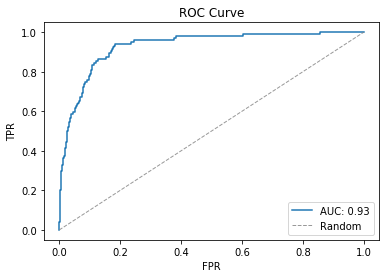

In [20]:
roc = roc_curve(y_prep_test, best_pred_test[:, 1])

label = 'AUC: {:.4}'.format(auc(roc[0], roc[1]))
plt.plot(roc[0], roc[1], label = label)
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray',label='Random', alpha=.8)
plt.legend()
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [21]:
precision, recall, _ = precision_recall_curve(y_prep_test, best_pred_test[:, 1])

Text(0, 0.5, 'Recall')

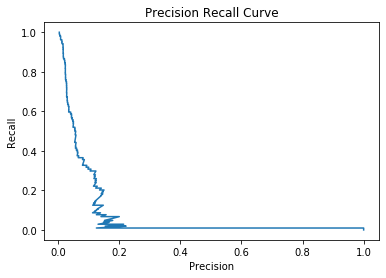

In [23]:
plt.plot(precision, recall)
plt.title("Precision Recall Curve")
plt.xlabel("Precision")
plt.ylabel("Recall")